In [ ]:
!pip3 install opencv-python 

# Imports

In [1]:
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils, optimizers
from PIL import Image
import shutil
from tensorflow.keras import models, layers
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

2023-03-08 16:05:31.084660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 16:05:31.208909: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 16:05:31.212010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dolly/.pyenv/versions/3.10.6/envs/YOGi/lib/python3.10/site-packages/cv2/../..

# Image Data Generator

In [2]:
root_dir = '../raw_data'
poses_list = os.listdir(root_dir) #Lists all folders in the root directory (raw_data folder)
poses_list

['Garland_Pose',
 'Peacock_Pose',
 'Four-Limbed_Staff',
 'Sitting_pose_1_(normal)',
 'Staff_Pose_',
 'Low_Lunge_pose',
 'Standing_big_toe_hold']

In [3]:
# Creates Testing and Training directories
def create_train_val_dirs(root_path):
    for pose in poses_list:
        if pose == "Testing" or pose == "Training":
            pass
        else:
            os.makedirs(os.path.join(root_path, 'Training', pose))
            os.makedirs(os.path.join(root_path, 'Testing', pose))
            
            
#Tries to create new directories
#Errors if Training/Testing directories already exist - delete them before running this notebook!
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [4]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """Function to split the data into train/test
    First checks that the image exists in the folder - this is a safety net for any images which don't exist that we missed when manually checking images 
    Creates a list of all images and randomises them
    Splits into train test depending on split size (defined below)
    Copies all the train images into train folder and vice versa
    """
    
    ignore = []
    for image in os.listdir(SOURCE_DIR):
        if type(cv2.imread(os.path.join(SOURCE_DIR, image))) is type(None):
            ignore.append(image)
    
    source_images = [image for image in os.listdir(SOURCE_DIR) if image not in ignore]
    # Randomising list
    source_images = random.sample(source_images, len(source_images))
    
    train_images = source_images[:int(SPLIT_SIZE * len(source_images))]
    val_images = source_images[int(SPLIT_SIZE * len(source_images)):]
    for image in train_images:
        shutil.copyfile(os.path.join(SOURCE_DIR, image), os.path.join(TRAINING_DIR, image))
    for image in val_images:
        shutil.copyfile(os.path.join(SOURCE_DIR, image), os.path.join(VALIDATION_DIR, image))
        

In [5]:
split_size = 0.7

#Loops over all the poses, defines the directories for source/train/test
#Splits the data into train/test
#Prints how many images are in train/test and in the original directory - sanity check!

for pose in poses_list:
    if pose == "Training" or pose == "Testing":
        pass
    else:
        SOURCE_DIR = f"{root_dir}/{pose}"
        TRAINING_DIR = f"{root_dir}/Training/{pose}"
        TESTING_DIR = f"{root_dir}/Testing/{pose}"    
        split_data(SOURCE_DIR, TRAINING_DIR, TESTING_DIR, split_size)

        print(f"There are {len(os.listdir(TRAINING_DIR))} images for {pose} in training")
        print(f"There are {len(os.listdir(TESTING_DIR))} images for {pose} in testing")

        print(f"Original {pose}'s directory has {len(os.listdir(SOURCE_DIR))} images\n")

There are 147 images for Garland_Pose in training
There are 64 images for Garland_Pose in testing
Original Garland_Pose's directory has 236 images



libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


There are 79 images for Peacock_Pose in training
There are 34 images for Peacock_Pose in testing
Original Peacock_Pose's directory has 177 images

There are 137 images for Four-Limbed_Staff in training
There are 59 images for Four-Limbed_Staff in testing
Original Four-Limbed_Staff's directory has 203 images



libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


There are 422 images for Sitting_pose_1_(normal) in training
There are 182 images for Sitting_pose_1_(normal) in testing
Original Sitting_pose_1_(normal)'s directory has 637 images

There are 49 images for Staff_Pose_ in training
There are 21 images for Staff_Pose_ in testing
Original Staff_Pose_'s directory has 72 images

There are 163 images for Low_Lunge_pose in training
There are 71 images for Low_Lunge_pose in testing
Original Low_Lunge_pose's directory has 295 images

There are 117 images for Standing_big_toe_hold in training
There are 51 images for Standing_big_toe_hold in testing
Original Standing_big_toe_hold's directory has 228 images



In [6]:
#These variables can be changes, excluding train_dir

train_dir = "../raw_data/Training"
img_height, img_width = 256, 256
batch_size = 32

In [7]:
#Splits into train_generator and validation_generator
#This bulk uploads the images
#Creates target (y) for us!

#Play around with the interpolation argument - bicubic, lanczos??? 

train_datagen = ImageDataGenerator(rescale=1./255,
                                    vertical_flip=True,
                                    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                    train_dir,
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='training',
                                    keep_aspect_ratio=True,
                                    interpolation='lanczos') # set as training data

validation_generator = train_datagen.flow_from_directory(
                                    train_dir, # same directory as training data
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='validation',
                                    keep_aspect_ratio=True,
                                    interpolation='lanczos') # set as validation data

Found 895 images belonging to 7 classes.
Found 219 images belonging to 7 classes.


# Model

In [10]:
def initialize_model():
    base_model = ResNet50(weights="imagenet"
                     , include_top=False
                     , input_shape=(img_height, img_width, 3))
    
    base_model.trainable = False
    
    model = models.Sequential([ 
        base_model,
        layers.Flatten(),
        layers.Dense(500, activation="relu"),
        layers.Dense(7, activation="softmax")
    ])
    
    
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
    return model

In [11]:
model = initialize_model()

2023-03-08 16:06:17.808196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dolly/.pyenv/versions/3.10.6/envs/YOGi/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-08 16:06:17.808325: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 16:06:17.808370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dolly): /proc/driver/nvidia/version does not exist
2023-03-08 16:06:17.809181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebui

94765736/94765736 [==============================] - 5s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 500)               65536500  
                                                                 
 dense_1 (Dense)             (None, 7)                 3507      
                                                                 
Total params: 89,127,719
Trainable params: 65,540,007
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
es = EarlyStopping(patience=1)

In [15]:
#fit model - fit on train_generator (both X and y) and the validation data is validation_generator
history = model.fit(
                train_generator,
                steps_per_epoch = train_generator.samples // batch_size,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size,
                epochs = 2,
                callbacks=[es])

Epoch 1/2
27/27 [==============================] - 57s 2s/step - loss: 3.0049 - accuracy: 0.3314 - val_loss: 1.7388 - val_accuracy: 0.4375
Epoch 2/2
27/27 [==============================] - 56s 2s/step - loss: 1.5202 - accuracy: 0.4577 - val_loss: 1.5802 - val_accuracy: 0.4740


In [16]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

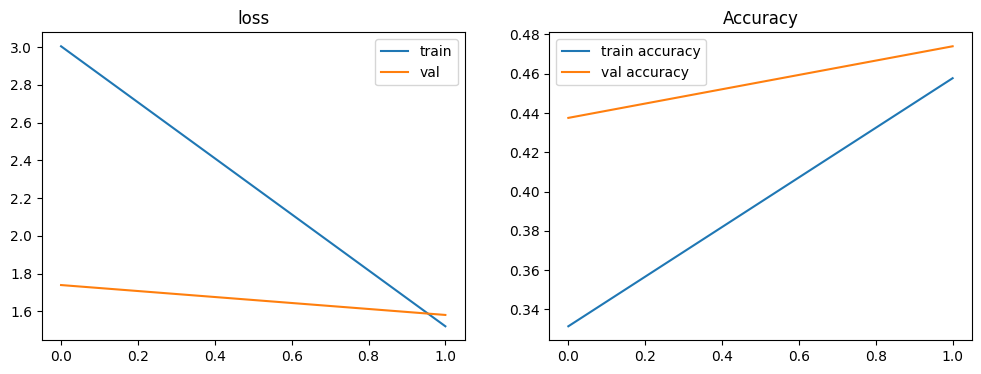

In [17]:
plot_history(history)

In [ ]:
test_dir = f"{root_dir}/Testing"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255) # set validation split

test_generator = test_datagen.flow_from_directory(
                                    test_dir,
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='training',
                                    keep_aspect_ratio=True,
                                    interpolation='lanczos') # set as training data

In [ ]:
model.evaluate(test_generator)

# Bounding Boxes

In [ ]:
#This has been paused and probably won't be used

In [ ]:
im = cv2.imread(f"{file_path}/{file_list[0]}")

In [ ]:
# Reading the Image
image = cv2.imread(f"{file_path}/{file_list[3]}")

# initialize the HOG descriptor
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

(humans, _) = hog.detectMultiScale(image, winStride=(3,3),
                                padding=(32, 32), 
                               scale=1.01)

# getting no. of human detected
print('Human Detected : ', len(humans))

# loop over all detected humans
for (x, y, w, h) in humans:
   pad_w, pad_h = int(0.15 * w), int(0.01 * h)
   cv2.rectangle(image, (x + pad_w, y + pad_h), (x + w - pad_w, y + h - pad_h), (0, 255, 0), 2)



In [ ]:
# display the output image
cv2.imshow("Image", image)
cv2.waitKey(25)
# cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
filepath = f"{file_path}/{file_list[3]}"
photo = cv2.imread(filepath)
photo_grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

In [ ]:
# Initializing the HOG person
# detector

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
   
# Reading the Image
image = cv2.imread(filepath)
   
# Detecting all the regions in the 
# Image that has a pedestrians inside it
(regions, _) = hog.detectMultiScale(image, 
                                    winStride=(8, 8),
                                    padding=(16, 16),
                                    scale=1.15)
   
# Drawing the regions in the Image
for (x, y, w, h) in regions:
    cv2.rectangle(image, (x, y), 
                  (x + w, y + h), 
                  (0, 0, 255), 2)
    
#Showing the output Image
cv2.imshow("Image", image)
cv2.waitKey(0)
   
cv2.destroyAllWindows()